In [1]:
!pip install "gymnasium[mujoco]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 6.6 MB/s eta 0:00:00


In [3]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque, namedtuple
import time
import matplotlib.pyplot as plt

In [4]:
ENV_NAME = 'InvertedPendulum-v4'
LEARNING_RATE = 1e-3
BUFFER_SIZE = 100000
BATCH_SIZE = 64
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 10000
TARGET_UPDATE_FREQ = 500
NUM_EPISODES = 500
MAX_TIMESTEPS = 500
N_DISCRETE_ACTIONS = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward', 'done'))

Using device: cpu


In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def store_transition(self, *args):
        self.memory.append(Transition(*args))

    def sample_minibatch(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.layer1 = nn.Linear(state_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

class DuelingQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingQNetwork, self).__init__()
        self.action_dim = action_dim

        self.feature_layer = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
        )
        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

In [7]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, agent_type='vanilla'):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.agent_type = agent_type.lower()

        if self.agent_type == 'dueling':
            self.q_network = DuelingQNetwork(state_dim, action_dim).to(device)
            self.target_network = DuelingQNetwork(state_dim, action_dim).to(device)
        else:
            self.q_network = QNetwork(state_dim, action_dim).to(device)
            self.target_network = QNetwork(state_dim, action_dim).to(device)

        self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayBuffer(BUFFER_SIZE)
        self.steps_done = 0

    def select_action(self, state):
        epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * \
                  np.exp(-1. * self.steps_done / EPSILON_DECAY)
        self.steps_done += 1

        if random.random() < epsilon:
            return torch.tensor([[random.randrange(self.action_dim)]], device=device, dtype=torch.long)
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                return q_values.max(1)[1].view(1, 1)

    def store_transition(self, state, action, next_state, reward, done):
        self.memory.store_transition(state, action, next_state, reward, done)

    def train_model(self):
        if len(self.memory) < BATCH_SIZE:
            return

        transitions = self.memory.sample_minibatch(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_action_values = self.q_network(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            if self.agent_type == 'vanilla' or self.agent_type == 'dueling':
                next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0]
            elif self.agent_type == 'double':
                next_actions = self.q_network(non_final_next_states).max(1)[1].unsqueeze(1)
                next_state_values[non_final_mask] = self.target_network(non_final_next_states).gather(1, next_actions).squeeze()

        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.q_network.parameters(), 100)
        self.optimizer.step()

In [8]:
def train_agent(env, agent, action_map):
    """Main training loop for a single agent."""
    print(f"\n--- Starting training for {agent.agent_type.capitalize()} DQN ---")
    start_time = time.time()
    total_steps = 0
    episode_rewards = []

    for i_episode in range(NUM_EPISODES):
        state, _ = env.reset()
        current_episode_reward = 0

        for t in range(MAX_TIMESTEPS):
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action_tensor = agent.select_action(state_tensor)
            action_index = action_tensor.item()

            continuous_action = [action_map[action_index]]

            next_state, reward, terminated, truncated, _ = env.step(continuous_action)
            done = terminated or truncated
            current_episode_reward += reward

            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) if not done else None
            reward_tensor = torch.tensor([reward], device=device)

            agent.store_transition(state_tensor, action_tensor, next_state_tensor, reward_tensor, done)
            state = next_state
            total_steps += 1
            agent.train_model()

            if total_steps % TARGET_UPDATE_FREQ == 0:
                agent.target_network.load_state_dict(agent.q_network.state_dict())

            if done:
                break

        episode_rewards.append(current_episode_reward)
        if (i_episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            print(f"Episode {i_episode+1}/{NUM_EPISODES} | Avg Reward (last 50): {avg_reward:.2f}")

    end_time = time.time()
    print(f"Training for {agent.agent_type.capitalize()} DQN took {end_time - start_time:.2f} seconds.")
    return episode_rewards

In [9]:
env = gym.make(ENV_NAME)
state_dim = env.observation_space.shape[0]
action_map = np.linspace(env.action_space.low[0], env.action_space.high[0], N_DISCRETE_ACTIONS)
action_dim = N_DISCRETE_ACTIONS
print(f"Discretized action space: {action_map}")

agent_types = ['vanilla', 'double', 'dueling']
all_scores = {}

for agent_type in agent_types:
    env.reset(seed=42)
    agent = DQNAgent(state_dim, action_dim, agent_type=agent_type)
    scores = train_agent(env, agent, action_map)
    all_scores[agent_type] = scores

env.close()

/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment InvertedPendulum-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Discretized action space: [-3.  0.  3.]

--- Starting training for Vanilla DQN ---
Episode 50/500 | Avg Reward (last 50): 5.02
Episode 100/500 | Avg Reward (last 50): 4.94
Episode 150/500 | Avg Reward (last 50): 5.00
Episode 200/500 | Avg Reward (last 50): 5.66
Episode 250/500 | Avg Reward (last 50): 6.76
Episode 300/500 | Avg Reward (last 50): 6.62
Episode 350/500 | Avg Reward (last 50): 6.04
Episode 400/500 | Avg Reward (last 50): 6.78
Episode 450/500 | Avg Reward (last 50): 6.12
Episode 500/500 | Avg Reward (last 50): 7.56
Training for Vanilla DQN took 10.46 seconds.

--- Starting training for Double DQN ---
Episode 50/500 | Avg Reward (last 50): 5.08
Episode 100/500 | Avg Reward (last 50): 4.74
Episode 150/500 | Avg Reward (last 50): 4.86
Episode 200/500 | Avg Reward (last 50): 5.40
Episode 250/500 | Avg Reward (last 50): 6.76
Episode 300/500 | Avg Reward (last 50): 5.92
Episode 350/500 | Avg Reward (last 50): 6.02
Episode 400/500 | Avg Reward (last 50): 7.20
Episode 450/500 | Avg 

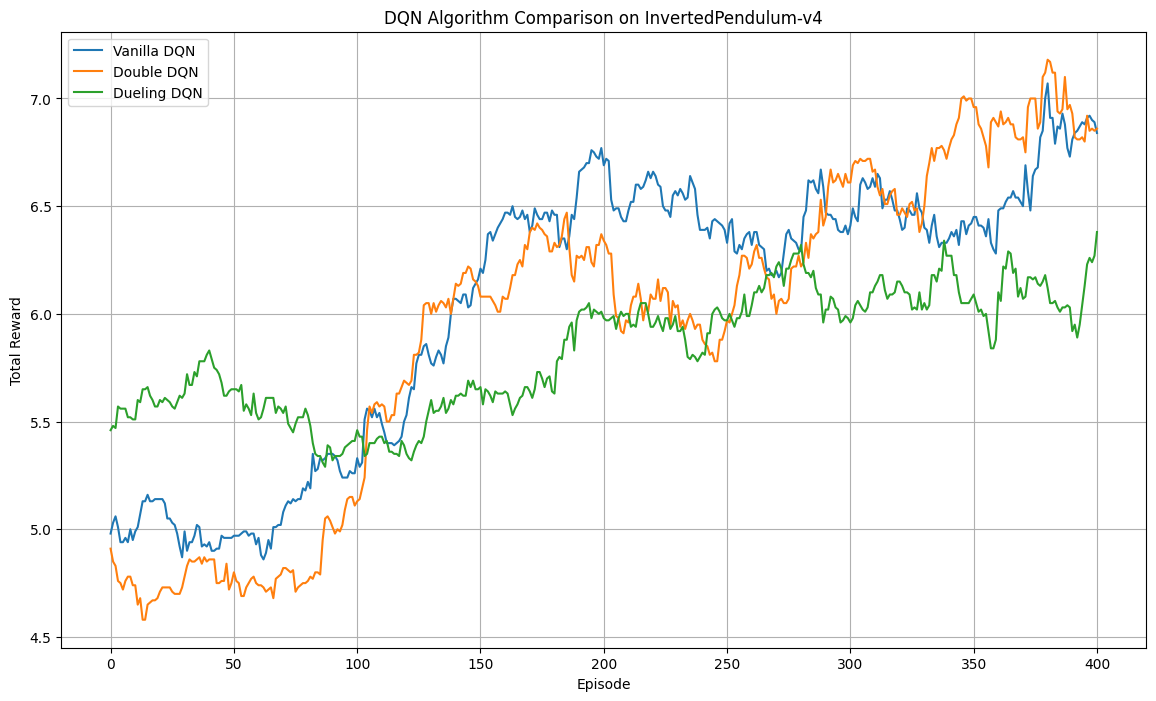

In [11]:
plt.figure(figsize=(14, 8))
for agent_type, rewards in all_scores.items():
  moving_avg = np.convolve(rewards, np.ones(100)/100, mode='valid')
  plt.plot(moving_avg, label=f'{agent_type.capitalize()} DQN')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title(f'DQN Algorithm Comparison on {ENV_NAME}')
plt.legend()
plt.grid(True)
plt.show()